In [1]:
import cryoenv.cryosig as cs
import numpy as np
import matplotlib.pyplot as plt
import pickle

%config InlineBackend.figure_formats = ['svg']

In [2]:
names = ['li1p', 'li1l', 'li2p']

pars = {}

name = names[0]

In [3]:
with open("saved_pars/{}_pars.pkl".format(name),"rb") as fh:
    pars[name] = pickle.load(fh)

In [4]:
# standard scenario
det = cs.DetectorModel(**pars[name])

In [5]:
det.delta_h = np.array([[0.05, .95]])

In [6]:
det.wait(5)

In [7]:
det.T

array([[36.02806501, 38.13943423],
       [36.02806501, 38.13943423],
       [36.02806501, 38.13943423],
       ...,
       [36.02806499, 38.13943421],
       [36.02806499, 38.13943421],
       [36.02806499, 38.13943421]])

set correct DAC

In [8]:
bnds = {'li1p': (0.,2.), }

res = det.solve_dac(det.kwargs['R_op_target'], bnds[name])

/Users/felix/.pyenv/versions/3.10.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [9]:
res

# li1p: 1.5876361223018052

1.1621355562801228

In [10]:
det.set_control(dac=np.array([res]), Ib=det.Ib)

In [11]:
det.wait(5)

In [12]:
det.T[-1]

array([30.7644467 , 32.05548296])

finetune pulse shape parameters

In [13]:
rranges = (slice(0, 1., 5e-2),
           slice(0, 2., 5e-2),
           slice(0, 1., 5e-2),
           )

resbrute = det.solve_time_constants([det.kwargs['tau_eff'], det.kwargs['tau_t']], rranges, print_iv=10000)

/Users/felix/PycharmProjects/cryoenv/cryoenv/cryosig/_detector_model.py:1099: RuntimeWarning: divide by zero encountered in double_scalars
  tau_t = 2 / (a - np.sqrt(a ** 2 - 4 * b))


done: 10000, total: 16000.0, 62.5 %, time passed: 0.9323210716247559
lowest loss: 2.3455807349580337e-08, G_eb, G_ab, G_ea = 0.15000000000000002, 1.5, 0.1


In [14]:
resbrute[0]

# li1p: array([0.15066647, 1.49821392, 0.09714942])

array([0.14999377, 1.49801768, 0.09768594])

find effective heater resistance

In [15]:
det.set_control(dac=pars[name]['dac'], Ib=det.Ib)

In [16]:
bnds = {'li1p': (1.,20.), }

res = det.solve_Rh(det.kwargs['R_op_target'], bnds[name])

In [17]:
res

# li1p: 16.160178109477126

9.159136624815684

find suitable epsilon

In [18]:
res = det.solve_collection_efficiency(5.9 * 8/9 + 1/9 * 6.4, 0.37, (0.01, 0.2))

In [19]:
res

# li1p: 0.11299957516260893

0.14117276126548453

find suitable pulser scaler

In [20]:
res = det.solve_pulser_scale(1., 0.2, (0.0, 0.2))

In [21]:
res

# li1p: 

0.10747747411771688

In [22]:
det.pulser_scale = np.array([0.09/4])

find suitable delta

In [23]:
res = det.solve_delta(1., 0.2, (0.0, 0.1))

In [24]:
res

0.051011427853931195

T0 is [30.84750302 35.80450386] mK.
Calculated in 0.6592249870300293 s.
Generated noise in 0.005729198455810547 s.


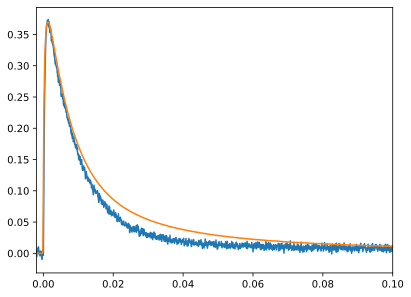

T0 is [30.84750302 35.80450386] mK.
Calculated in 0.67976975440979 s.
Generated noise in 0.007266044616699219 s.


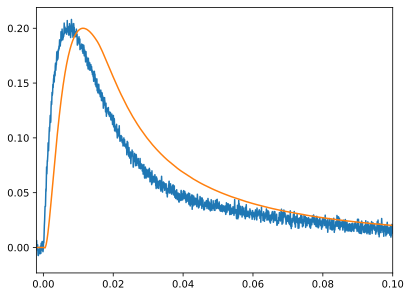

30.84751031641442 0.0748860806028305


In [25]:
det.wait(5)

det.trigger(er=np.array([0., (5.9 * 8/9 + 1/9 * 6.4)]), tpa=np.array([0.0]))

evsim = det.get_record()

plt.plot(det.kwargs['sev'][:,0], evsim)
plt.plot(det.kwargs['sev'][:,0] + 0.0026, det.kwargs['sev'][:,1]*0.37)
plt.xlim(-0.002,0.1)
plt.show()

det.wait(5)

det.trigger(er=np.array([0., 0.]), tpa=np.array([1.]))

evsim = det.get_record()

plt.plot(det.kwargs['sev_tp'][:,0], evsim)
plt.plot(det.kwargs['sev_tp'][:,0], det.kwargs['sev_tp'][:,1]*0.2)
plt.xlim(-0.002,0.1)
plt.show()

print(det.T[-1,0], det.Rt[0](det.T[-1,0]))

T0 is [30.84750302 35.80450386] mK.
Calculated in 0.6915819644927979 s.
Generated noise in 0.006015777587890625 s.


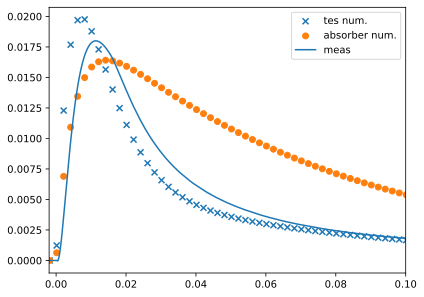

In [26]:
# det.set_control(dac=[1.662], Ib=[5], norm=False)

det.wait(5)

tp = True

if not tp:
    det.trigger(er=np.array([0., (5.9 * 8/9 + 1/9 * 6.4)]), tpa=np.array([0.0]))
else:
    det.trigger(er=np.array([0., 0.]), tpa=np.array([1.0]))

evsim = det.get_record()

temps = det.get_temperatures()
thermal_ps = det.get_thermal_pulseshape(5.9 * 8/9 + 1/9 * 6.4)

if not tp:
    plt.plot(det.t - det.t0, thermal_ps[0], label='tes anal.')
    plt.plot(det.t - det.t0, thermal_ps[1], label='absorber anal.')
plt.scatter(det.t[::50] - det.t0, temps[::50,0] - np.mean(temps[:2000,0]), label='tes num.', marker='x')
plt.scatter(det.t[::50] - det.t0, temps[::50,1] - np.mean(temps[:2000,1]), label='absorber num.', marker='o')
if not tp:
    plt.plot(det.kwargs['sev'][:,0] + 0.0026, det.kwargs['sev'][:,1]*0.035, label='meas')
else:
    plt.plot(det.kwargs['sev_tp'][:,0], det.kwargs['sev_tp'][:,1]*0.0180, label='meas')
plt.legend()
plt.xlim(-0.002,0.1)
plt.show()

fit noise parameters

In [27]:
det.flicker_slope = np.array([1.5])

In [28]:
det.tes_fluct = np.array([8e-5])
# det.solve_tes_fluctuations(nps=det.kwargs['nps'][:,1])
# hm does not work very well automatically

In [29]:
# det.solve_johnson_excess(det.kwargs['nps'][:,1])  # hmm i think we are comparing differnt units
det.excess_johnson = np.array([4])

In [30]:
# det.solve_emi(det.kwargs['nps'][:,1])
det.emi = np.array([[1.5e-5, 1.e-5, 1.5e-5]])

sets see all together in action

In [31]:
# det.set_control(dac=[1.99], Ib=[5], norm=False)

det.wait(5)

det.trigger(er=np.array([0., 5.95]), tpa=np.array([0.0]))

det.ph

T0 is [30.84750302 35.80450386] mK.
Calculated in 0.7420108318328857 s.
Generated noise in 0.0074307918548583984 s.


array([0.37925563])

In [32]:
nps_shubham = np.loadtxt('../../rltest_data/Ch01_NPS.xy', skiprows=4)
nps_shubham[:,1] *= 2 / det.sample_frequency / 0.875 / det.eta ** 2  #  / det.record_length

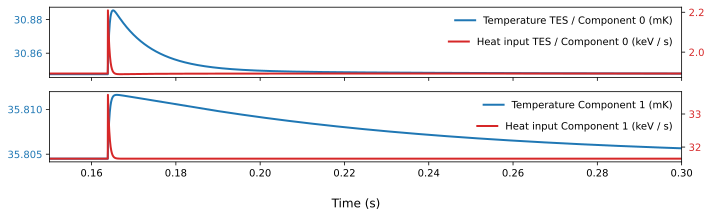

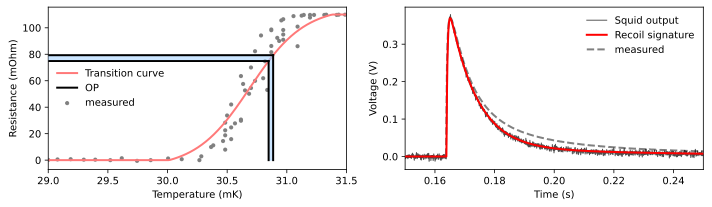

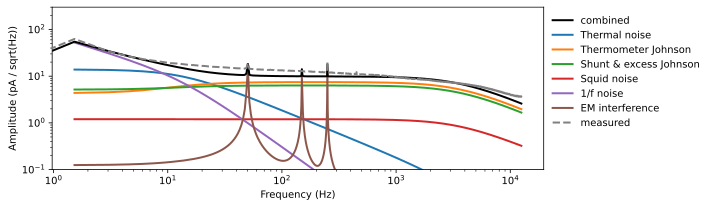

In [33]:
det.plot_temperatures(save_path='plots_paper/temperatures.png', xlim=(0.15, 0.3), dpi=300)

fig, axes = det.plot_tes(xlim_temp=(29., 31.5), xlim_time=(0.15, 0.25), save_path=None, show=False, dpi=300)  # 'plots_paper/tes.png'
axes[0].scatter(pars[name]['transition_curve'][:,0], 1e3*(pars[name]['transition_curve'][:,1] - 0.012)*110/(110-12), 
                rasterized=True, color='grey', s=10, label='measured')
axes[1].plot(det.kwargs['sev'][:,0] + 0.0026 + 0.16384, det.kwargs['sev'][:,1]*0.37, linestyle='dashed', color='grey', linewidth=2, label='measured')
axes[0].set_title('')
axes[1].set_title('')
axes[0].legend(frameon=False)
axes[1].legend(frameon=False)
plt.tight_layout()
plt.savefig('plots_paper/tes.png')
plt.show()

for i in range(det.nmbr_tes):
    det.plot_nps(tes_channel=i, only_sum=False, save_path=None, show=False, dpi=300)  # 'plots_paper/nps_tes_{}.png'.format(i)
    #plt.loglog(det.kwargs['nps'][:,0], np.sqrt(det.kwargs['nps'][:,1])*1e6, color='grey', linestyle='dashed', linewidth=2, label='measured', zorder=100)
    plt.loglog(nps_shubham[:,0], np.sqrt(nps_shubham[:,1])*1e6, color='grey', linestyle='dashed', linewidth=2, label='measured', zorder=100)
    plt.legend(frameon=False, bbox_to_anchor=(1., 1.))
    plt.ylim(1e-1, 3e2)
    plt.title('')
    plt.tight_layout()
    plt.savefig('plots_paper/nps_tes_{}.png'.format(i))
    plt.show()

In [34]:
det.print_noise_parameters()

Resistance TES / Resistance normal conducting: 0.6807746418854065
Temperature mixing chamber: 15.0 mK
Temperature TES: 30.8475030169846 mK
Resistance TES: 74.88521060739471 mOhm
Tau eff: 11.883046277040508 ms
TES Slope: 119.18676623715697 mOhm/mK
C: 3086.16117128571 fJ / K 
Geff: 259.71128104150773 pW / K
Tau in: 20.57526303252423 ms
Geb: 149.99376515416975 pW / K 
G ETF: 109.717515887338 pW / K 
R shunt: 40.0 mOhm
Temperature shunt: 15.0 mK
i sq: 1.2 pA/sqrt(Hz)
1 / f amplitude (pW): 8e-05 
1 / f power (flicker slope): 1.5 
Tau el (s): 3.0465192007705808e-06 
Tau I (s): -0.014603389319479727 
L_I (): 2.408937513230474 


In [35]:
import copy

pars_cryoenv = copy.deepcopy(pars)

pars_cryoenv[name]['Gb'] = det.Gb
pars_cryoenv[name]['G'] = det.G 
pars_cryoenv[name]['Rh'] = det.Rh
pars_cryoenv[name]['eps'] = det.eps
pars_cryoenv[name]['pulser_scale'] = det.pulser_scale
pars_cryoenv[name]['delta'] = det.delta
pars_cryoenv[name]['delta_h'] = det.delta_h
pars_cryoenv[name]['flicker_slope'] = det.flicker_slope
pars_cryoenv[name]['tes_fluct'] = det.tes_fluct
pars_cryoenv[name]['excess_johnson'] = det.excess_johnson
pars_cryoenv[name]['emi'] = det.emi


In [36]:
fname = 'saved_pars/{}_pars_cryoenv.pkl'.format(name)

with open(fname, 'wb') as fh:
    pickle.dump(pars_cryoenv[name], fh)
    print('dictionary saved successfully to file {}'.format(fname))
    

dictionary saved successfully to file saved_pars/li1p_pars_cryoenv.pkl


In [37]:
name_load = 'li1p'

with open("saved_pars/{}_pars_cryoenv.pkl".format(name_load),"rb") as fh:
    pars_load = pickle.load(fh)

In [38]:
pars_load

{'C': array([0.0021189 , 0.11278459]),
 'Gb': array([0.14999377, 1.49801768]),
 'G': array([[0.        , 0.09768594],
        [0.09768594, 0.        ]]),
 'lamb': array([0.00038245, 0.00038245]),
 'lamb_tp': array([0.00497]),
 'eps': array([[0.99     , 0.01     ],
        [0.1411657, 0.8588343]]),
 'Rs': array([0.04]),
 'Rh': array([9.15913662]),
 'L': array([3.5e-07]),
 'Rt0': array([0.11]),
 'k': array([4.39882698]),
 'Tc': array([30.692]),
 'Ib': array([5.0008]),
 'dac': array([1.58]),
 'pulser_scale': array([0.0225]),
 'heater_current': array([4.79808]),
 'eta': array([5.76666667]),
 'tes_flag': array([ True, False]),
 'heater_flag': array([False,  True]),
 'i_sq': array([1.2]),
 'tes_fluct': array([8.e-05]),
 'flicker_slope': array([1.5]),
 'emi': array([[1.5e-05, 1.0e-05, 1.5e-05]]),
 'tau_cap': array([1]),
 'Ib_range': (0.0, 17.86),
 'excess_johnson': array([4]),
 'R_op_target': 0.06448418672455546,
 'tau_eff': 0.00935751479,
 'tau_t': 0.07205835566,
 'nps': array([[0.00000000e+